In [1]:
import pandas as pd
cols = [
    "status","duration","crediPreprocessing pipeline and train-test splitt_history","purpose","amount",
    "savings","employment","installment_rate","personal_status",
    "guarantors","residence","property","age","other_installment",
    "housing","credits","job","dependents","phone","foreign_worker",
    "target"
]
df = pd.read_csv("../data/german.data", sep=" ", names=cols)
df.head()

,status,duration,crediPreprocessing pipeline and train-test splitt_history,purpose,amount,savings,employment,installment_rate,personal_status,guarantors,...,property,age,other_installment,housing,credits,job,dependents,phone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [2]:
df["target"].value_counts(normalize=True)

target
1    0.7
2    0.3
Name: proportion, dtype: float64

In [3]:
df["target_binary"] = df["target"].map({1: 0, 2: 1})

In [4]:
df[["target", "target_binary"]].head()

,target,target_binary
0,1,0
1,2,1
2,1,0
3,1,0
4,2,1


In [5]:
X = df.drop(columns=["target", "target_binary"])
y = df["target_binary"]

X.shape, y.shape

((1000, 20), (1000,))

In [6]:
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

cat_cols, num_cols

/var/folders/pt/w30j5vtd1qj0nfnj2n1869hw0000gn/T/ipykernel_52597/1006655460.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X.select_dtypes(include="object").columns


(Index(['status', 'crediPreprocessing pipeline and train-test splitt_history',
        'purpose', 'savings', 'employment', 'personal_status', 'guarantors',
        'property', 'other_installment', 'housing', 'job', 'phone',
        'foreign_worker'],
       dtype='str'),
 Index(['duration', 'amount', 'installment_rate', 'residence', 'age', 'credits',
        'dependents'],
       dtype='str'))

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((800, 20), (200, 20))

In [10]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape

((800, 61), (200, 61))

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

In [12]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_train_processed, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [13]:
y_train_proba = log_reg.predict_proba(X_train_processed)[:, 1]
y_test_proba = log_reg.predict_proba(X_test_processed)[:, 1]

In [14]:
roc = roc_auc_score(y_test, y_test_proba)
pr = average_precision_score(y_test, y_test_proba)

print(f"ROC-AUC: {roc:.3f}")
print(f"PR-AUC:  {pr:.3f}")

ROC-AUC: 0.806
PR-AUC:  0.633


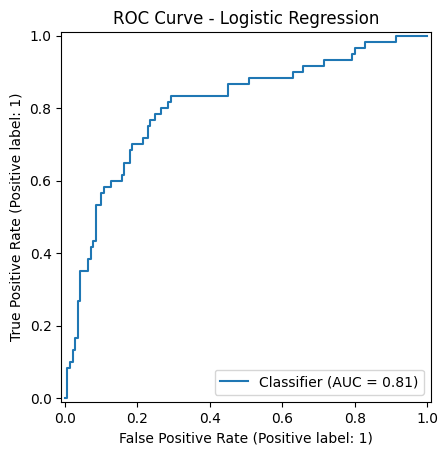

In [15]:
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve - Logistic Regression")
plt.show()

In [16]:
import numpy as np

print("Mean predicted prob:", np.mean(y_test_proba))
print("Actual positive rate:", np.mean(y_test))

Mean predicted prob: 0.44793958180487264
Actual positive rate: 0.3


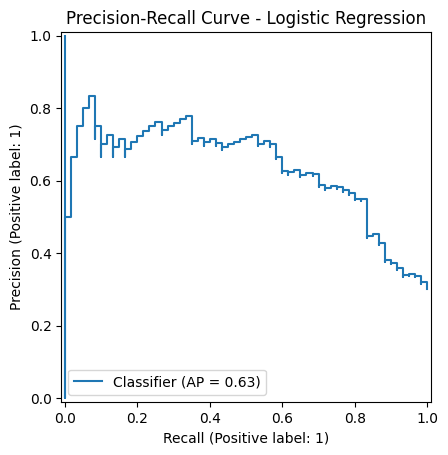

In [17]:
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve - Logistic Regression")
plt.show()

In [18]:
y_test_pred = (y_test_proba >= 0.5).astype(int)

print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.89      0.73      0.80       140
           1       0.56      0.80      0.66        60

    accuracy                           0.75       200
   macro avg       0.73      0.76      0.73       200
weighted avg       0.79      0.75      0.76       200



In [19]:
from sklearn.calibration import calibration_curve

In [20]:
prob_true, prob_pred = calibration_curve(
    y_test,
    y_test_proba,
    n_bins=10,
    strategy="uniform"
)

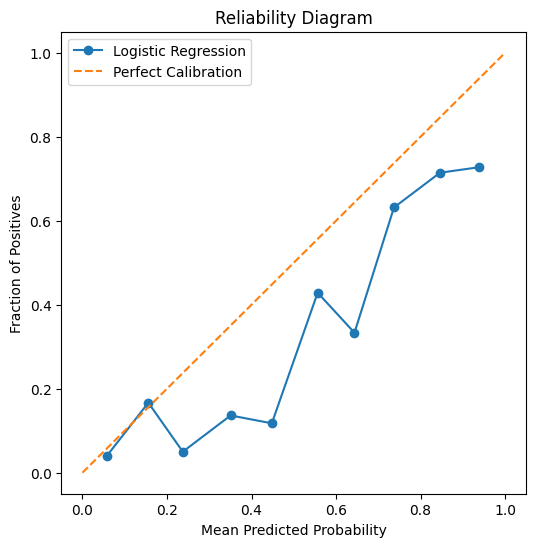

In [21]:
plt.figure(figsize=(6,6))

plt.plot(prob_pred, prob_true, marker='o', label="Logistic Regression")
plt.plot([0,1],[0,1], linestyle="--", label="Perfect Calibration")

plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Reliability Diagram")
plt.legend()
plt.show()

In [22]:
from sklearn.calibration import CalibratedClassifierCV


In [23]:
calibrated_lr_sigmoid = CalibratedClassifierCV(
    log_reg,
    method="sigmoid",
    cv=5
)

calibrated_lr_sigmoid.fit(X_train_processed, y_train)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",LogisticRegre...ndom_state=42)
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'sigmoid'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprec

In [24]:
y_test_proba_sigmoid = calibrated_lr_sigmoid.predict_proba(X_test_processed)[:,1]

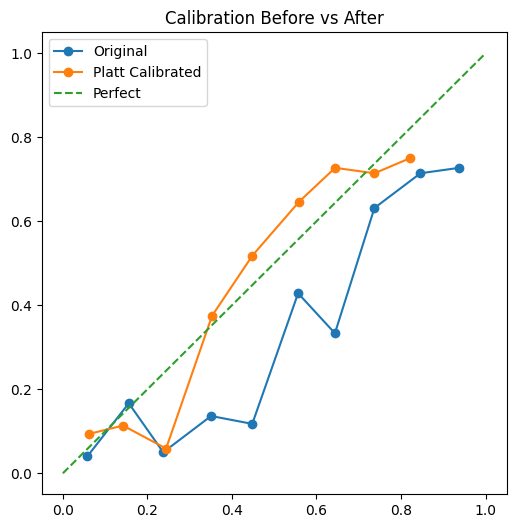

In [25]:
prob_true_s, prob_pred_s = calibration_curve(
    y_test,
    y_test_proba_sigmoid,
    n_bins=10
)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label="Original")
plt.plot(prob_pred_s, prob_true_s, marker='o', label="Platt Calibrated")
plt.plot([0,1],[0,1],'--',label="Perfect")

plt.legend()
plt.title("Calibration Before vs After")
plt.show()

In [26]:
from sklearn.metrics import brier_score_loss

brier_original = brier_score_loss(y_test, y_test_proba)
brier_sigmoid = brier_score_loss(y_test, y_test_proba_sigmoid)

print("Brier Score (Original):", round(brier_original, 4))
print("Brier Score (Platt):   ", round(brier_sigmoid, 4))


Brier Score (Original): 0.1824
Brier Score (Platt):    0.1562


In [27]:
calibrated_lr_iso = CalibratedClassifierCV(
    log_reg,
    method="isotonic",
    cv=5
)

calibrated_lr_iso.fit(X_train_processed, y_train)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",LogisticRegre...ndom_state=42)
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'isotonic'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. depre

In [28]:
y_test_proba_iso = calibrated_lr_iso.predict_proba(X_test_processed)[:,1]

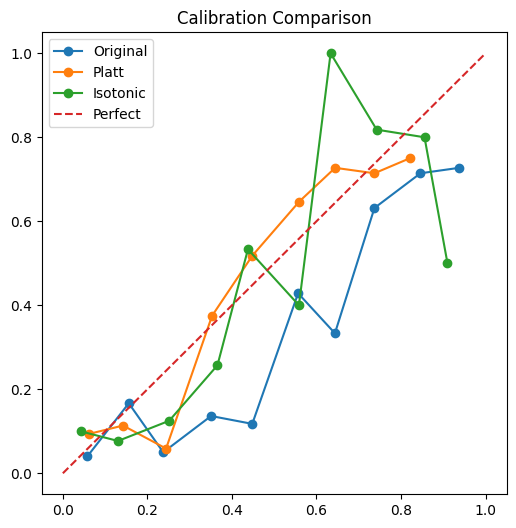

In [29]:
prob_true_i, prob_pred_i = calibration_curve(
    y_test,
    y_test_proba_iso,
    n_bins=10
)

plt.figure(figsize=(6,6))

plt.plot(prob_pred, prob_true, 'o-', label="Original")
plt.plot(prob_pred_s, prob_true_s, 'o-', label="Platt")
plt.plot(prob_pred_i, prob_true_i, 'o-', label="Isotonic")
plt.plot([0,1],[0,1],'--',label="Perfect")

plt.legend()
plt.title("Calibration Comparison")
plt.show()

In [30]:
confidence = np.abs(y_test_proba_sigmoid - 0.5) * 2

In [31]:
thresholds = np.linspace(0, 1, 11)

results = []

for t in thresholds:
    mask = confidence >= t
    
    if mask.sum() == 0:
        continue
        
    acc = ( (y_test_pred[mask] == y_test[mask]).mean() )
    coverage = mask.mean()
    
    results.append((t, coverage, acc))
    
results


[(np.float64(0.0), np.float64(1.0), np.float64(0.75)),
 (np.float64(0.1), np.float64(0.905), np.float64(0.7624309392265194)),
 (np.float64(0.2), np.float64(0.78), np.float64(0.8012820512820513)),
 (np.float64(0.30000000000000004),
  np.float64(0.665),
  np.float64(0.8571428571428571)),
 (np.float64(0.4), np.float64(0.605), np.float64(0.8925619834710744)),
 (np.float64(0.5), np.float64(0.51), np.float64(0.8823529411764706)),
 (np.float64(0.6000000000000001), np.float64(0.4), np.float64(0.8875)),
 (np.float64(0.7000000000000001),
  np.float64(0.305),
  np.float64(0.8852459016393442)),
 (np.float64(0.8), np.float64(0.16), np.float64(0.90625)),
 (np.float64(0.9), np.float64(0.055), np.float64(1.0))]

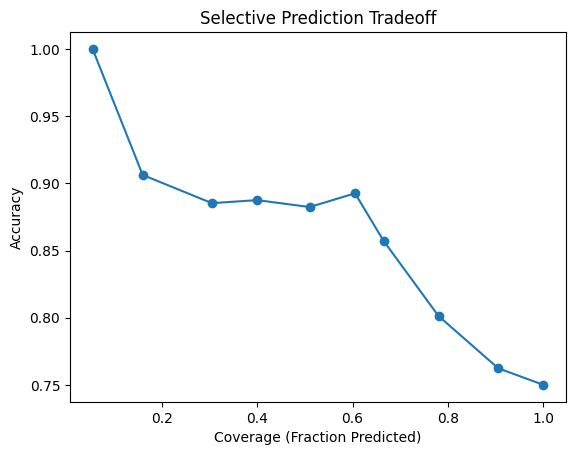

In [32]:
thr, cov, acc = zip(*results)

plt.plot(cov, acc, marker='o')
plt.xlabel("Coverage (Fraction Predicted)")
plt.ylabel("Accuracy")
plt.title("Selective Prediction Tradeoff")
plt.show()

In [33]:
import numpy as np

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    n = len(y_true)

    for i in range(n_bins):
        mask = bin_ids == i
        if np.sum(mask) == 0:
            continue

        acc = np.mean(y_true[mask])
        conf = np.mean(y_prob[mask])

        ece += (np.sum(mask) / n) * np.abs(acc - conf)

    return ece


In [34]:
ece_original = expected_calibration_error(y_test.values, y_test_proba)
ece_platt = expected_calibration_error(y_test.values, y_test_proba_sigmoid)
ece_iso = expected_calibration_error(y_test.values, y_test_proba_iso)

print("ECE (Original):", round(ece_original,4))
print("ECE (Platt):   ", round(ece_platt,4))
print("ECE (Isotonic):", round(ece_iso,4))


ECE (Original): 0.1512
ECE (Platt):    0.0692
ECE (Isotonic): 0.1004
